In [49]:
import pandas as pd
from pandas import DataFrame
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import torch
print(torch.cuda.is_available())

True


In [66]:
df=pd.read_csv("sars_2003_complete_dataset_clean.csv")
ndf=df.loc[df['Country'] == 'Hong Kong SAR, China']
tot=3000
ndf=ndf.drop(labels='Country',axis=1)
ndf=ndf.drop(labels='Date',axis=1)
ndf['Number recovered']=(ndf['Number recovered']+ndf['Number of deaths'])
ndf=ndf.drop(labels='Number of deaths',axis=1)
ndf['infected']=ndf['Cumulative number of case(s)']-ndf['Number recovered'].shift(1)
ndf=ndf.drop("Cumulative number of case(s)",axis=1)
ndf=ndf.fillna(95)
ndf['sus']=tot-ndf.iloc[:,0:].sum(axis=1)
ndf=ndf.reindex(columns=['sus','infected','Number recovered'])

In [67]:
ndf=ndf/tot
datasize=96

In [68]:
ndf=ndf.iloc[0:datasize,:]
print(ndf)

           sus  infected  Number recovered
3     0.968000  0.031667          0.000333
11    0.959000  0.040667          0.000333
20    0.948667  0.049667          0.001667
32    0.942000  0.056000          0.002000
45    0.932333  0.065667          0.002000
...        ...       ...               ...
2386  0.415000  0.009000          0.576000
2417  0.415000  0.009000          0.576000
2448  0.414667  0.009000          0.576333
2479  0.415000  0.008667          0.576333
2510  0.414333  0.008667          0.577000

[96 rows x 3 columns]


(96, 4)
28


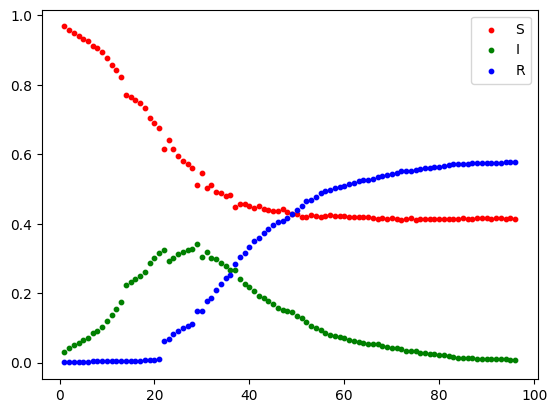

In [69]:
xxx=np.arange(1,datasize+1)
xxx=xxx.reshape(datasize,1)
narray=np.array(ndf)
xarray=np.concatenate((narray,xxx),axis=1)
print(xarray.shape)
s=xarray[:,0]
i=xarray[:,1]
r=xarray[:,2]
x=xarray[:,3]
besttval=-1
mxval=-1
for ii in range(0,xarray.shape[0]):
    if i[ii]>mxval:
        mxval=i[ii]
        besttval=ii
print(besttval)
plt.figure()
plt.scatter(x,s,c='red',s=10,)
plt.scatter(x,i,c='green',s=10)
plt.scatter(x,r,c='blue',s=10)
plt.legend(['S','I','R'],loc='best')
plt.show()

In [54]:
def gen_traindata():
    data = narray
    return np.arange(1,datasize+1),narray

In [55]:
beta = dde.Variable(0.1)
gamma = dde.Variable(0.1)

In [56]:
def ode_system(x, y):
    S, I,R = y[:, 0:1], y[:, 1:2], y[:,2:3]
    ds_x = dde.grad.jacobian(y, x, i=0)
    di_x = dde.grad.jacobian(y, x, i=1)
    dr_x = dde.grad.jacobian(y, x, i=2)
    return [ds_x+beta*I*S, di_x-beta*I*S+gamma*I, dr_x-gamma*I,S+I+R-1]

In [57]:
def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, 150)
ic1 = dde.icbc.IC(geom, lambda x: 0.968, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 0.031667, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda x: 0.000333, boundary, component=2)

In [58]:
layer_size = [1,20,80,256,40,3]
activation = "elu"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)
observe_t, ob_y = gen_traindata()
observe_S = dde.icbc.PointSetBC(observe_t[:,None].astype(float), ob_y[:, 0:1].astype(float), component=0)
observe_I = dde.icbc.PointSetBC(observe_t[:,None].astype(float), ob_y[:, 1:2].astype(float), component=1)
observe_R = dde.icbc.PointSetBC(observe_t[:,None].astype(float), ob_y[:, 2:3].astype(float), component=2)

In [59]:
data = dde.data.PDE(
    geom,
    ode_system,
    [ic1, ic2, ic3, observe_S, observe_I, observe_R],
    num_domain=400,
    num_boundary=10,
    anchors=observe_t[:,None].astype(float),
)

In [60]:
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[beta, gamma])
variable = dde.callbacks.VariableValue(
   [beta, gamma], period=600, filename="variables.dat"
)
losshistory, train_state = model.train(iterations=50000,callbacks=[variable])
# train lbfgs

Compiling model...
'compile' took 0.000187 s

Training model...

0         [1.31e+00, 9.28e-01, 1.05e-02, 8.21e+01, 9.37e-01, 1.00e-03, 1.11e-07, 2.81e-01, 2.14e-02, 3.05e-01]    [1.31e+00, 9.28e-01, 1.05e-02, 8.21e+01, 9.37e-01, 1.00e-03, 1.11e-07, 2.81e-01, 2.14e-02, 3.05e-01]    []  
1000      [3.57e-05, 5.58e-05, 3.79e-05, 1.58e-05, 5.72e-07, 1.96e-08, 2.39e-08, 1.22e-04, 9.05e-05, 5.33e-06]    [3.57e-05, 5.58e-05, 3.79e-05, 1.58e-05, 5.72e-07, 1.96e-08, 2.39e-08, 1.22e-04, 9.05e-05, 5.33e-06]    []  
2000      [2.38e-05, 2.86e-05, 1.60e-05, 8.31e-06, 4.20e-07, 5.72e-08, 1.98e-09, 7.90e-05, 6.46e-05, 2.36e-06]    [2.38e-05, 2.86e-05, 1.60e-05, 8.31e-06, 4.20e-07, 5.72e-08, 1.98e-09, 7.90e-05, 6.46e-05, 2.36e-06]    []  
3000      [1.86e-05, 2.38e-05, 5.37e-06, 1.72e-05, 1.87e-07, 3.13e-08, 1.97e-11, 7.12e-05, 5.96e-05, 2.05e-06]    [1.86e-05, 2.38e-05, 5.37e-06, 1.72e-05, 1.87e-07, 3.13e-08, 1.97e-11, 7.12e-05, 5.96e-05, 2.05e-06]    []  
4000      [1.28e-05, 1.65e-05, 2.03e-06, 3.

In [61]:
print(beta,gamma)

tensor(0.1170, requires_grad=True) tensor(0.0064, requires_grad=True)


In [62]:
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])

NameError: name 'external_trainable_variables' is not defined

In [63]:
from deepxde.utils.external import *
def pack_data(train_state):
    def merge_values(values):
        if values is None:
            return None
        return np.hstack(values) if isinstance(values, (list, tuple)) else values

    y_train = merge_values(train_state.y_train)
    y_test = merge_values(train_state.y_test)
    best_y = merge_values(train_state.best_y)
    best_ystd = merge_values(train_state.best_ystd)
    return y_train, y_test, best_y, best_ystd
s = pack_data(train_state)

In [64]:
def myplot_best_state(train_state):
    """Plot the best result of the smallest training loss.

    This function only works for 1D and 2D problems. For other problems and to better
    customize the figure, use ``save_best_state()``.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        train_state: ``TrainState`` instance. The second variable returned from
            ``Model.train()``.
    """
    if isinstance(train_state.X_train, (list, tuple)):
        print(
            "Error: The network has multiple inputs, and plotting such result han't been implemented."
        )
        return

    y_train, y_test, best_y, best_ystd = pack_data(train_state)
    y_dim = best_y.shape[1]
    print(best_y.shape)
    besttval=-1
    mxval=-1
    for ii in range(0,best_y.shape[0]):
        if best_y[ii,1]>mxval:
            mxval=best_y[ii,1]
            besttval=ii
    # Regression plot
    # 1D
    if train_state.X_test.shape[1] == 1:
        idx = np.argsort(train_state.X_test[:, 0])
        X = train_state.X_test[idx, 0]
        plt.figure()
        for i in range(y_dim):
            if y_train is not None:
                plt.plot(train_state.X_train[:, 0], y_train[:, i], "ok", label="Train")
            if y_test is not None:
                plt.plot(X, y_test[idx, i], "-k", label="True")
            if i==0:
                plt.plot(X, best_y[idx, i], color='red', label="S")
            elif i==1:
                plt.plot(X, best_y[idx, i], color='green', label="I")
            else:
                plt.plot(X, best_y[idx, i], color='blue', label="R")
            if best_ystd is not None:
                plt.plot(
                    X, best_y[idx, i] + 2 * best_ystd[idx, i], "-b", label="95% CI"
                )
                plt.plot(X, best_y[idx, i] - 2 * best_ystd[idx, i], "-b")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        print(besttval)
        print(mxval)
    # 2D
    elif train_state.X_test.shape[1] == 2:
        for i in range(y_dim):
            plt.figure()
            ax = plt.axes(projection=Axes3D.name)
            ax.plot3D(
                train_state.X_test[:, 0],
                train_state.X_test[:, 1],
                best_y[:, i],
                ".",
            )
            ax.set_xlabel("$x_1$")
            ax.set_ylabel("$x_2$")
            ax.set_zlabel("$y_{}$".format(i + 1))


(514, 3)
491
0.7815343


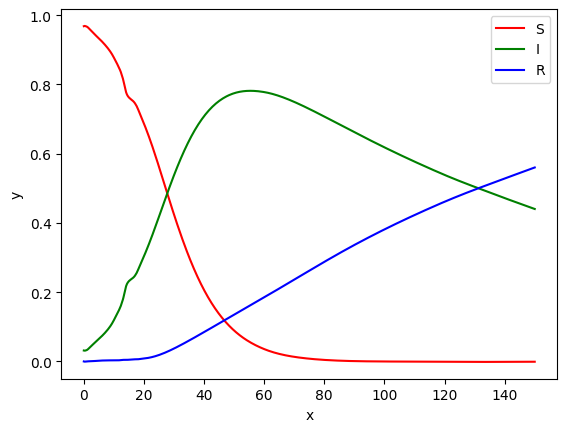

In [65]:
myplot_best_state(train_state)